# Requirements

In [1]:
# !pip install --upgrade transformers bertviz checklist

# Data loading

In [2]:
# !rm -rf ru_news_cause_v1.tsv*
# !wget https://www.dropbox.com/s/kcxnhjzfut4guut/ru_news_cause_v1.tsv.tar.gz
# !tar -xzvf ru_news_cause_v1.tsv.tar.gz

In [3]:
# !cat ru_news_cause_v1.tsv | wc -l
# !head ru_news_cause_v1.tsv

# GPTCause

In [3]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
device = 'cuda'
model_id = 'sberbank-ai/rugpt3small_based_on_gpt2' 
 
model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

2021-08-01 15:30:34.664821: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [21]:
import torch
max_length = model.config.n_positions

def gpt_assess(s1, s2):
    encodings = tokenizer(f'{s1} {s2}', return_tensors='pt')
    with torch.no_grad():
        outputs = model(encodings.input_ids.to(device), labels=encodings.input_ids.to(device))
        log_likelihood = outputs[0] * encodings.input_ids.size(1)
    return log_likelihood.detach().cpu().numpy()

def gpt_assess_pair(s1,s2):
    ppl1 = gpt_assess(s1,s2)
    ppl2 = gpt_assess(s2,s1)
    if ppl1<ppl2:
        return 0, ppl1/ppl2
    else:
        return 1, ppl1/ppl2

In [22]:
print(gpt_assess('Привет!', 'Как дела?'))
print(gpt_assess('Как дела?', 'Привет!'))
print(gpt_assess_pair('Как дела?', 'Привет!'))
print(gpt_assess_pair('Привет!', 'Как дела?'))


11.083624
23.637806
(1, 2.1326785)
(0, 0.46889395)


## Scoring

In [23]:
import csv

labels = []
texts = []
preds = []
confs = []

with open("ru_news_cause_v1.tsv", "r", encoding='utf-8') as r:
    reader = csv.reader(r, delimiter="\t")
    header = next(reader)
    for row in reader:
        r = dict(zip(header, row))
        if float(r["confidence"]) < 0.69:
            continue
        result = r["result"]
        mapping = {
            "left_right_cause": 0,
            "left_right_cancel": 0,
            "right_left_cause": 1,
            "right_left_cancel": 1
        }
        if result not in mapping:
            continue
        r["label"] = mapping[result]
        
        labels.append(r['label'])
        texts.append( (r["left_title"], r["right_title"] ) )
        p, c = gpt_assess_pair( r["left_title"], r["right_title"] )
        preds.append( p )
        confs.append( c )


In [24]:
from collections import Counter

print('labels', Counter(labels))
print('preds', Counter(preds))

labels Counter({1: 763, 0: 706})
preds Counter({1: 742, 0: 727})


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


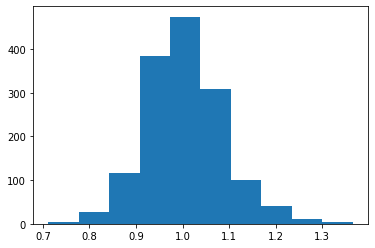

In [25]:
import matplotlib.pyplot as plt

plt.hist(confs)
plt.show()

In [18]:
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
y_true = labels
y_pred = preds

print(classification_report(y_true, y_pred))
print('balanced_accuracy_score', balanced_accuracy_score(y_true, y_pred))
print('\nconfusion_matrix\n',confusion_matrix(y_true, y_pred))



              precision    recall  f1-score   support

           0       0.58      0.60      0.59       706
           1       0.62      0.60      0.61       763

    accuracy                           0.60      1469
   macro avg       0.60      0.60      0.60      1469
weighted avg       0.60      0.60      0.60      1469

balanced_accuracy_score 0.5976343938308228

confusion_matrix
 [[421 285]
 [306 457]]


In [32]:
import numpy as np

confidence_th = .1

mask = np.array(list(map(lambda x:abs(x-1.), confs)))>confidence_th

y_true = np.array(labels)[mask]
y_pred = np.array(preds)[mask]

print(classification_report(y_true, y_pred))
print('balanced_accuracy_score', balanced_accuracy_score(y_true, y_pred))
print('\nconfusion_matrix\n',confusion_matrix(y_true, y_pred))



              precision    recall  f1-score   support

           0       0.73      0.67      0.70       139
           1       0.72      0.78      0.75       153

    accuracy                           0.73       292
   macro avg       0.73      0.72      0.72       292
weighted avg       0.73      0.73      0.73       292

balanced_accuracy_score 0.7234212629896083

confusion_matrix
 [[ 93  46]
 [ 34 119]]


In [40]:
from sklearn.metrics import f1_score

xs = []
ys = []
for th_idx in range(250):
    th = th_idx/1000.
    mask = np.array(list(map(lambda x:abs(x-1.), confs)))>th

    y_true = np.array(labels)[mask]
    y_pred = np.array(preds)[mask]
    xs.append( th )
    ys.append( f1_score(y_true, y_pred) )


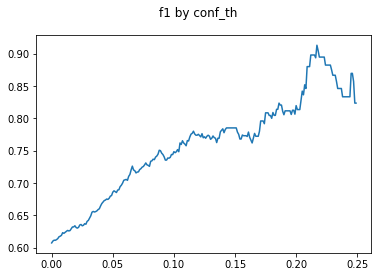

In [44]:
import matplotlib.pyplot as plt

plt.plot(xs, ys)
plt.suptitle('f1 by conf_th')
plt.show()